In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from configparser import ConfigParser

from src.IA_models import load_data, KFold_XY, plot_SHAP, plot_AUC, \
    plot_recall, plot_precision, generate_model_report

C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-projet-hive\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config: ConfigParser = ConfigParser()
config.read("config.ini")

DATA_DIRECTORY: str = config["GENERAL"]["DataDirectory"]
METRICS_DIRECTORY: str = "data/full_metrics"
N_SPLITS: int = int(config["IA"]["NSplits"])
SHUFFLE: bool = config["IA"].getboolean("Shuffle")
RANDOM_STATE: int = int(config["IA"]["RandomState"])
N_ESTIMATORS: int = int(config["IA"]["nEstimators"])

data_dict: dict = load_data(METRICS_DIRECTORY)
data_dict

2.0.0_full_metrics.csv
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4484    0.0
4485    0.0
4486    0.0
4487    0.0
4488    0.0
Name: CCViolDensityLine, Length: 4489, dtype: float64 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4484    0.0
4485    0.0
4486    0.0
4487    0.0
4488    0.0
Name: CCViolDensityLine, Length: 4489, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4484    0.0
4485    0.0
4486    0.0
4487    0.0
4488    0.0
Name: CCViolDensityCode, Length: 4489, dtype: float64 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4484    0.0
4485    0.0
4486    0.0
4487    0.0
4488    0.0
Name: CCViolDensityCode, Length: 4489, dtype: float64
0       0.11
1       0.11
2       0.14
3       0.95
4       0.24
        ... 
4484    0.03
4485    0.81
4486    0.01
4487    0.08
4488    1.55
Name: RatioCommentToCode, Length: 4489, dtype: float64 0       0.11
1       0.11
2       0

{'2.0.0_full_metrics.csv':                                   Name  AvgCountLine  AvgCountLineBlank  \
 0                      AMReporter.java          11.0                0.0   
 1                      ASTBuilder.java          12.0                0.0   
 2                    ASTConverter.java          17.0                1.0   
 3                    ASTErrorNode.java           2.0                0.0   
 4                         ASTNode.java          10.0                1.0   
 ...                                ...           ...                ...   
 4484               thrift_grammar.java          44.0                0.0   
 4485      thrift_grammarConstants.java           0.0                0.0   
 4486   thrift_grammarTokenManager.java          42.0                0.0   
 4487  thrift_grammarTreeConstants.java           0.0                0.0   
 4488           thriftserverconstants.h           0.0                0.0   
 
       AvgCountLineCode  AvgCountLineComment  AvgCyclomatic 

### Prepare data
The commit version, its ID, and the file name are not considered in the model training. All columns containing a NaN are unusable and removed.

In [3]:
XY_dict: dict = {}
for key in data_dict.keys():
    data: pd.DataFrame = data_dict[key]
    X = data.drop(columns=['BugStatus', 'Name', 'BugCount', 'Priority']).dropna(axis=1)  # independent variables
    y = data['BugStatus']  # presence of a bug
    y_priority = data['Priority']  # priority of the bug
    XY_dict[key] = (X, y)
XY_dict.keys()

dict_keys(['2.0.0_full_metrics.csv', '2.1.0_full_metrics.csv', '2.2.0_full_metrics.csv', '2.3.0_full_metrics.csv', '3.0.0_full_metrics.csv', '3.1.0_full_metrics.csv', '4.0.0_full_metrics.csv'])

In [4]:
y.head(3)

0    1
1    0
2    0
Name: BugStatus, dtype: int64

In [5]:
y_priority.head(3)

0    3
1    0
2    0
Name: Priority, dtype: int64

### Training and test data
The entire dataset is divided into 10 equal parts on which the model is trained. Validation is performed [using cross-validation](https://medium.com/@tubelwj/five-methods-for-data-splitting-in-machine-learning-27baa50908ed) to more accurately determine the effectiveness of our model.

In [6]:
XY_training_dict: dict = {}
XY_testing_dict: dict = {}
for key in XY_dict.keys():
    X, y = XY_dict[key]
    X_train, X_test, y_train, y_test = KFold_XY(N_SPLITS, SHUFFLE, RANDOM_STATE, X, y)
    XY_training_dict[key] = (X_train, y_train)
    XY_testing_dict[key] = (X_test, y_test)

### Model Training

Comparison between logistic regression and random forest.

In [7]:
logistic_regression_models: dict = {}
random_forest_models: dict = {}

for key in XY_training_dict:
    X_train, y_train = XY_training_dict[key]
    log_model = LogisticRegression(max_iter=10_000_000_000)
    random_model = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

    log_model.fit(X_train, y_train)
    random_model.fit(X_train, y_train)

    logistic_regression_models[key] = log_model
    random_forest_models[key] = random_model

C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-projet-hive\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-projet-hive\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

---

## Evaluation of the model performance
### Prediction

In [8]:
logistic_regression_predictions: dict = {}
random_forest_prediction: dict = {}

for key in XY_testing_dict:
    X_test, y_test = XY_testing_dict[key]
    random_forest_prediction[key] = random_forest_models[key].predict(X_test)
    logistic_regression_predictions[key] = logistic_regression_models[key].predict(X_test)

### Evaluation

The 2 models are compared by their AUC, precision, and recall. The **random forest** is a better model for determining the presence of bugs in a commit.

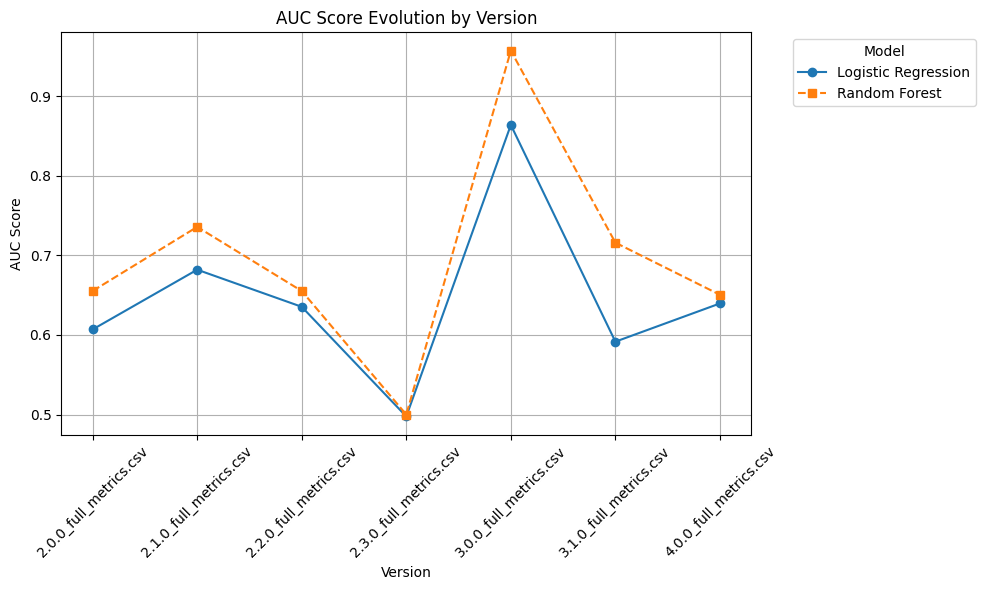

In [9]:
y_test: dict = {key: XY_testing_dict[key][1] for key in XY_testing_dict.keys()}
y_pred_log: dict = {key: logistic_regression_predictions[key] for key in logistic_regression_predictions.keys()}
y_pred_rf: dict = {key: random_forest_prediction[key] for key in random_forest_prediction.keys()}
plot_AUC(y_test, y_pred_log, y_pred_rf)

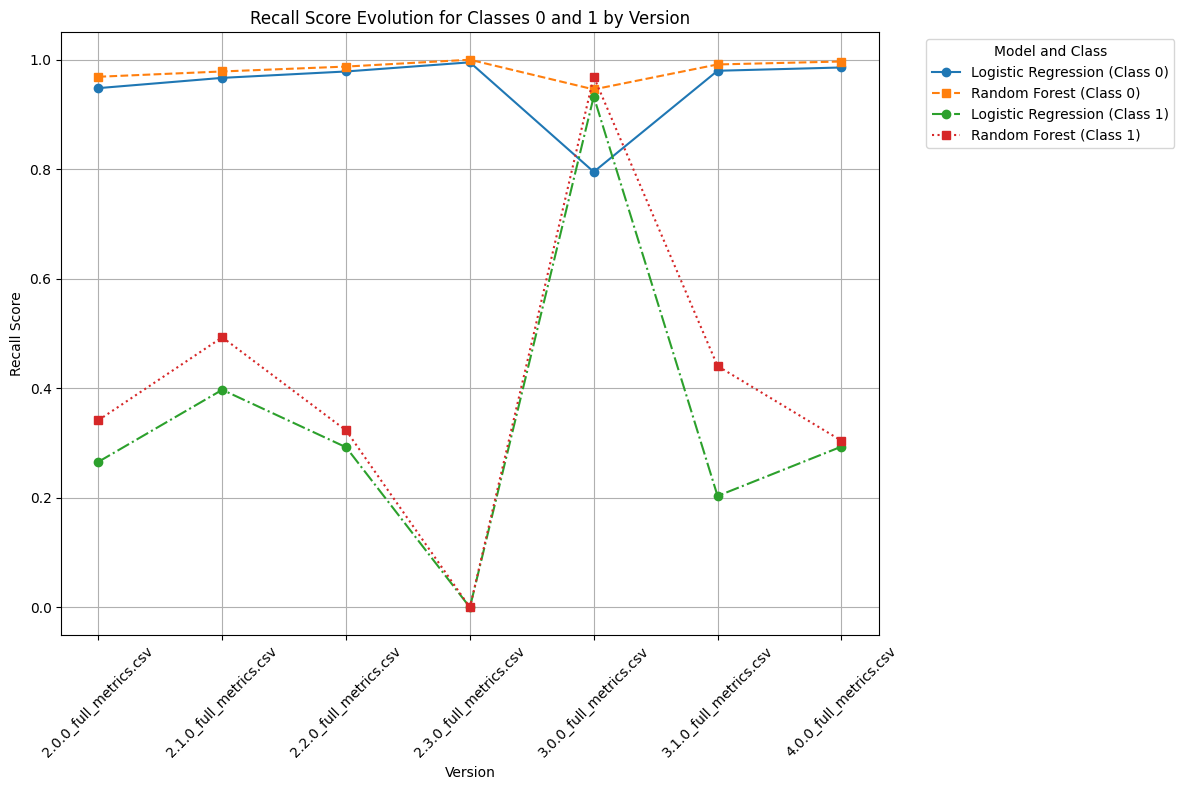

In [10]:
plot_recall(y_test, y_pred_log, y_pred_rf)


C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-projet-hive\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


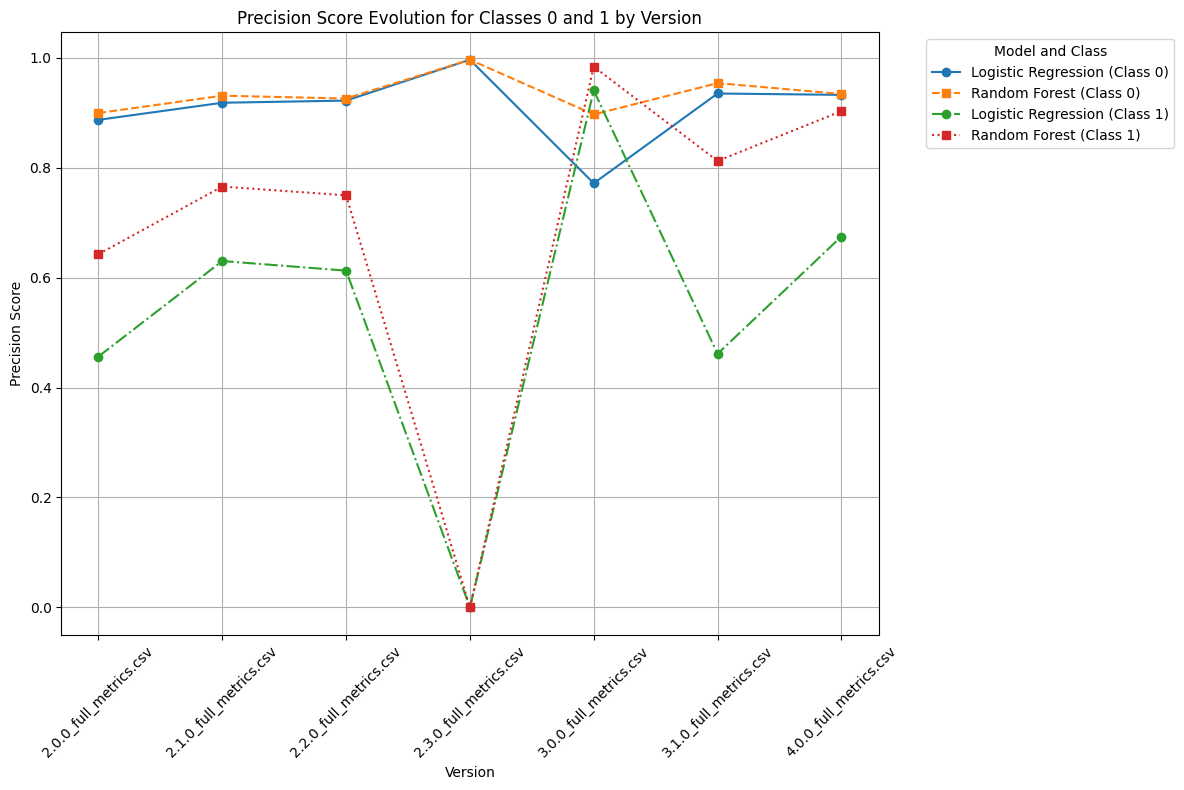

In [11]:
plot_precision(y_test, y_pred_log, y_pred_rf)

In [12]:
generate_model_report(y_test, y_pred_log, y_pred_rf)

C:\Users\moshi\Documents\projects\Informatique\ETS\MGL869\MGL869-projet-hive\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Version,Model,Precision 0,Precision 1,Recall 0,Recall 1
0,2.0.0_full_metrics.csv,Logistic Regression,0.887379,0.456522,0.948133,0.265823
1,2.0.0_full_metrics.csv,Random Forest,0.899807,0.642857,0.968880,0.341772
2,2.1.0_full_metrics.csv,Logistic Regression,0.918519,0.630435,0.966862,0.397260
3,2.1.0_full_metrics.csv,Random Forest,0.931354,0.765957,0.978558,0.493151
4,2.2.0_full_metrics.csv,Logistic Regression,0.922428,0.612903,0.978533,0.292308
5,2.2.0_full_metrics.csv,Random Forest,0.926174,0.750000,0.987478,0.323077
6,2.3.0_full_metrics.csv,Logistic Regression,0.996830,0.000000,0.995253,0.000000
7,2.3.0_full_metrics.csv,Random Forest,0.996845,0.000000,1.000000,0.000000
8,3.0.0_full_metrics.csv,Logistic Regression,0.771930,0.940870,0.795181,0.932759
9,3.0.0_full_metrics.csv,Random Forest,0.897143,0.984238,0.945783,0.968966


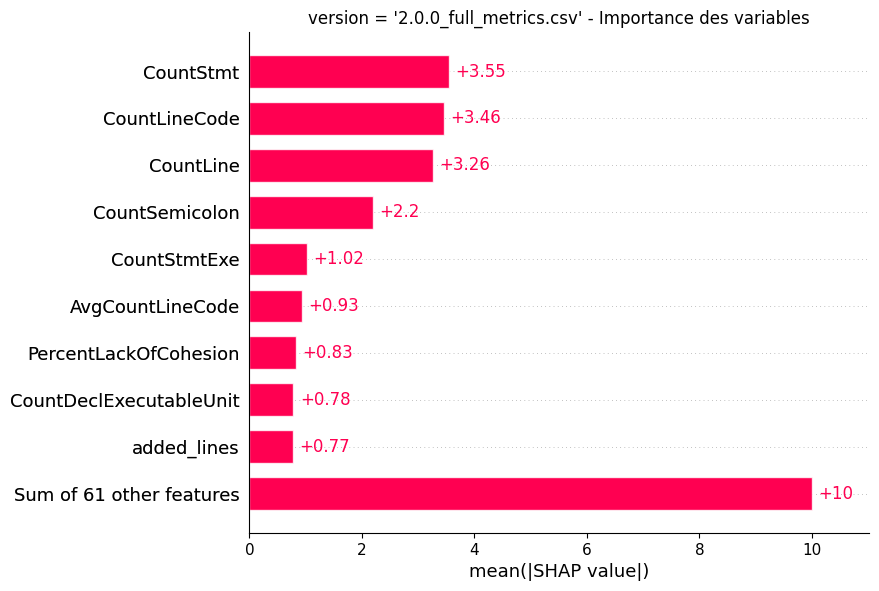

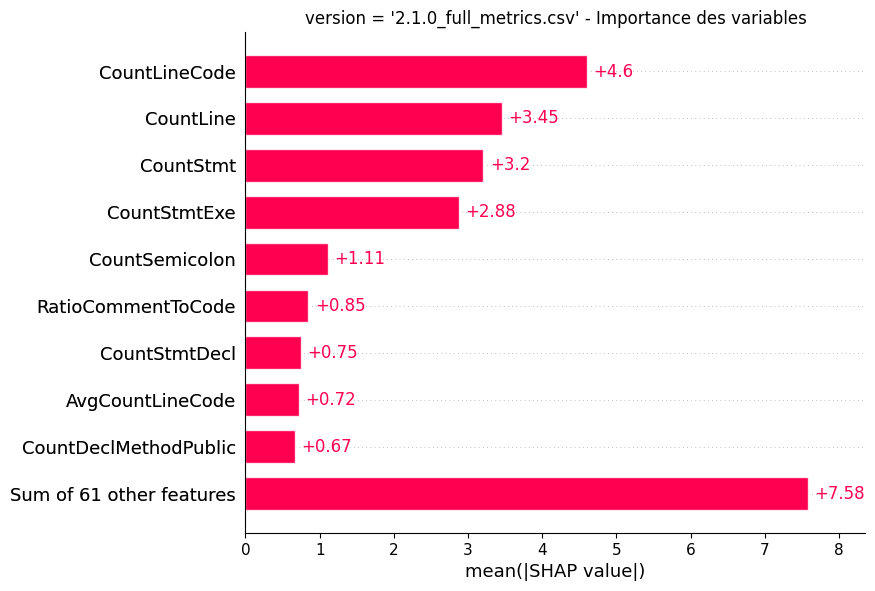

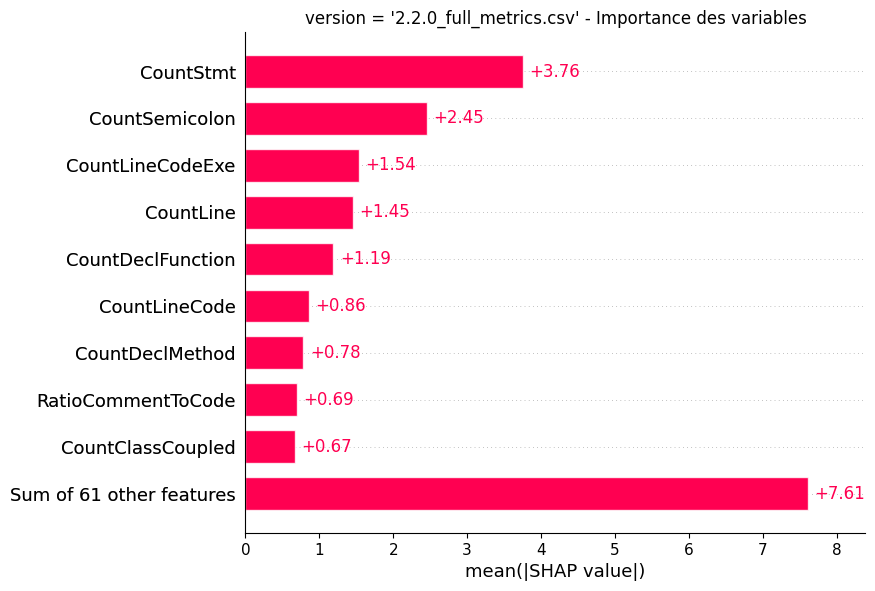

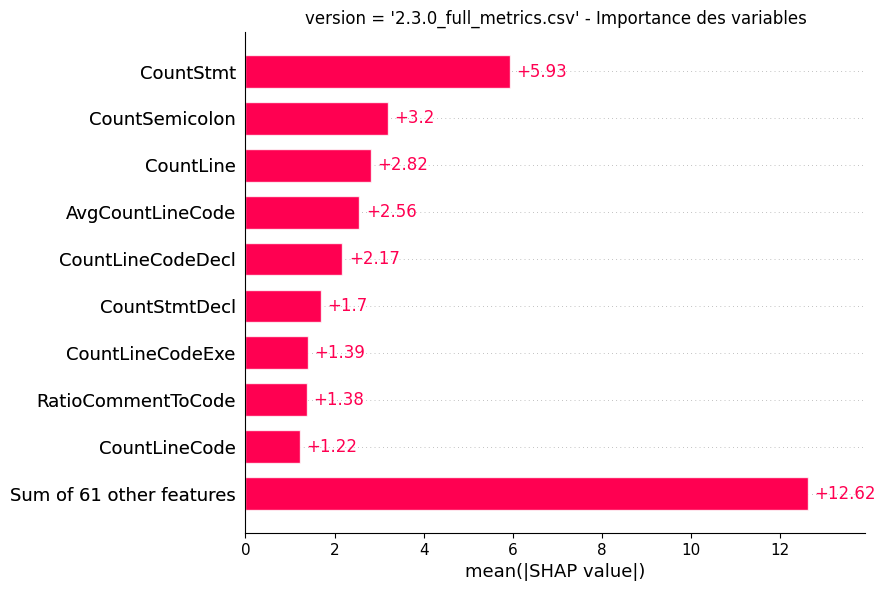

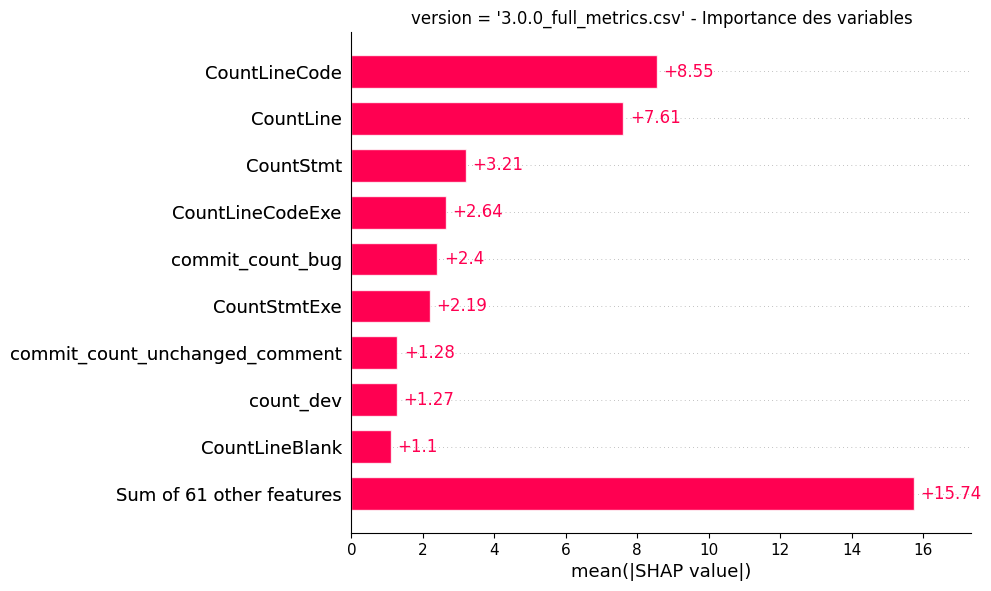

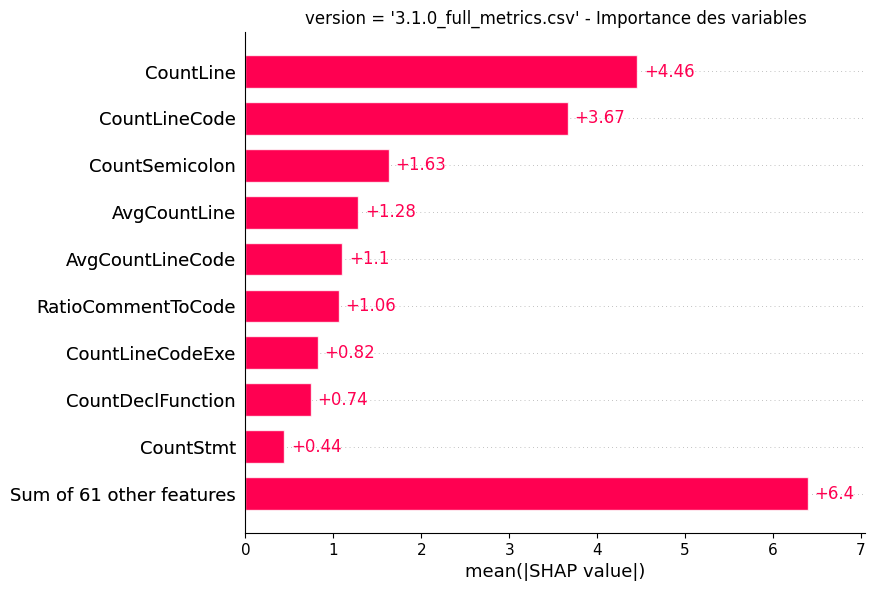

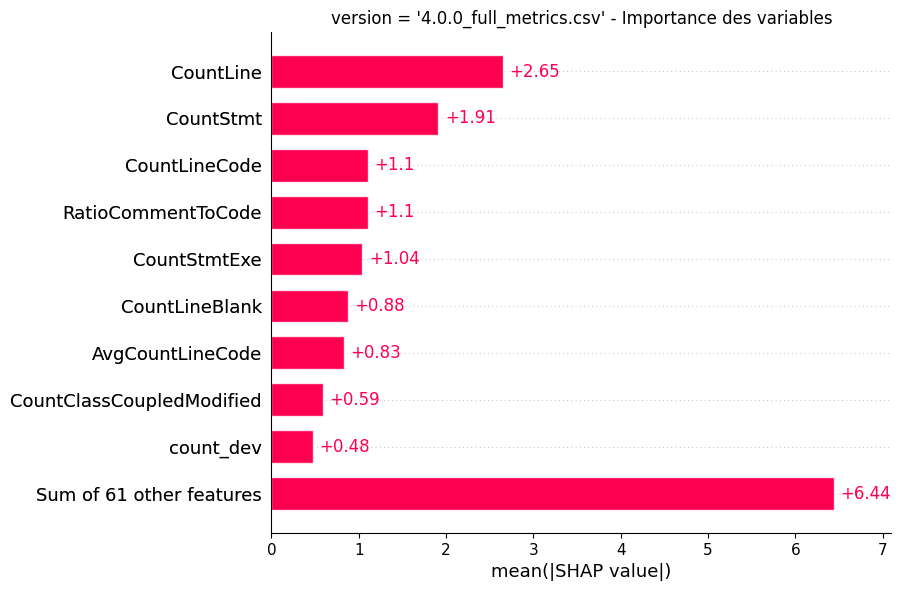

In [13]:
shap_values_versions = {}
for key in logistic_regression_models:
    shap_values = plot_SHAP(logistic_regression_models[key], XY_training_dict[key][0], XY_testing_dict[key][0], key)
    shap_values_versions[key] = shap_values

## Actions to take
### Reduce code complexity
`CountLineCode` and `CountStmtExe` are important variables for bug prediction. Indeed, the larger the `CountLineCode` and `CountStmtExe`, the more likely the presence of a bug in the file.

**Solution**: Adopt a modular architecture.

**Example**: HiveConf.java contained 3249 lines of code and 676 statements in release-2.0.0. It could be broken down into several modules, even if these modules exist but have few lines of code (HiveConfUtil.java which contains 8 lines of code and 5 statements).

2.0.0_full_metrics.csv


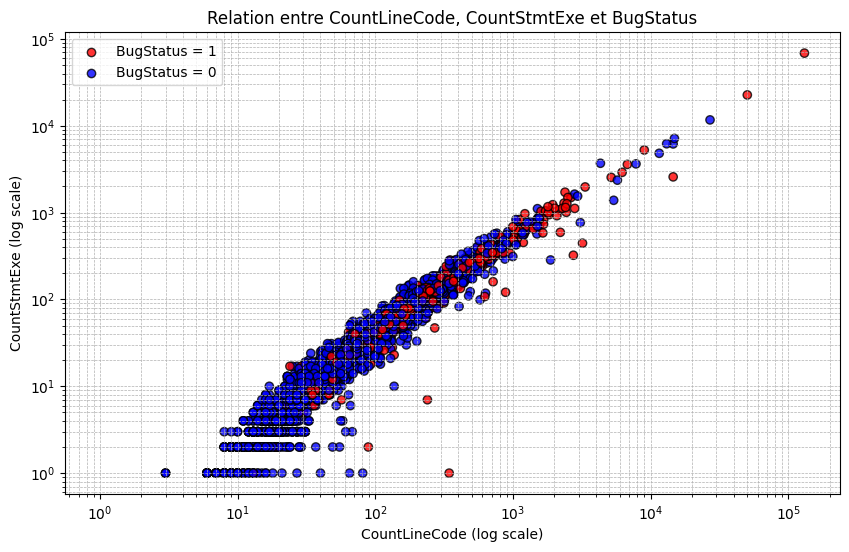

In [14]:
versions: list = list(data_dict.keys())
print(versions[0])
data_2_0_0 = data_dict[versions[0]]

plt.figure(figsize=(10, 6))
colors = data_2_0_0['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data_2_0_0['CountLineCode'], data_2_0_0['CountStmtExe'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('CountLineCode (log scale)')
plt.ylabel('CountStmtExe (log scale)')
plt.title('Relation entre CountLineCode, CountStmtExe et BugStatus')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.scatter([], [], c='red', label='BugStatus = 1', alpha=0.8, edgecolors='k')
plt.scatter([], [], c='blue', label='BugStatus = 0', alpha=0.8, edgecolors='k')
plt.legend()

plt.show()

### Promote better code readability
CountLines is an important variable. The larger the CountLines, the more likely the presence of a bug in the file.  Solution: Uniformly format the code (adhere to coding standards), add relevant and concise comments, simplify the code.

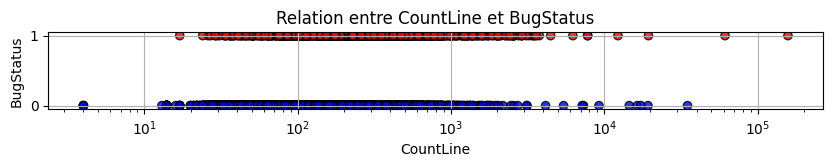

In [15]:
plt.figure(figsize=(10, 1))
colors = data_2_0_0['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data_2_0_0['CountLine'], data_2_0_0['BugStatus'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.xlabel('CountLine')
plt.ylabel('BugStatus')
plt.title('Relation entre CountLine et BugStatus')
plt.grid(True)
plt.show()

### Eliminate unnecessary declarations
CountStmtDecl indicates an excess of variables.  Solution: Remove unnecessary variables, methods, and classes, and reuse already declared variables, methods, and classes.

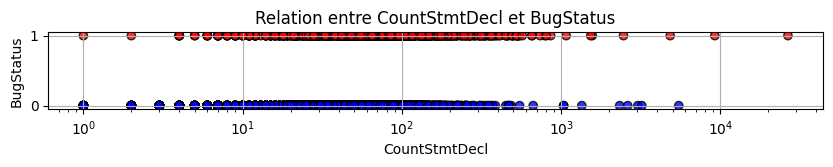

In [16]:
plt.figure(figsize=(10, 1))
colors = data_2_0_0['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data_2_0_0['CountStmtDecl'], data_2_0_0['BugStatus'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.xlabel('CountStmtDecl')
plt.ylabel('BugStatus')
plt.title('Relation entre CountStmtDecl et BugStatus')
plt.grid(True)
plt.show()

### Keep logs for each execution
CountStmtExe is an important variable. This indicates that most bugs come from executable statements.  Solution: Adopt logging in all files containing executable statements.  Example: TSetIpAddressProcessor.java contains logging and has no bugs, whereas ASTBuilder.java does not have logging and has a bug.

### Develop and automate more tests
Given the importance of `CountStmtExe`, this may require more unit tests.

**Solution**: Improve test coverage by automating them for each commit.

# Evolution of the most important metrics by version


In [17]:
best_metrics = set()
metrics_values = {}
for key in shap_values_versions.keys():
    version_title = key[:3]
    shap_values = shap_values_versions[key]
    X_test = XY_testing_dict[key][0]
    # Extraire les noms des features depuis X_test
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]
    # Calculer l'importance moyenne absolue des SHAP values pour chaque feature
    shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
    # Trouver les indices des deux features les plus importantes
    top_2_indices = np.argsort(shap_mean_importance)[-3:][::-1]
    # Extraire les noms et les valeurs des deux features les plus importantes
    top_2_features = []
    for i in top_2_indices:
        top_2_features.append((feature_names[i], shap_mean_importance[i]))
        best_metrics.add(feature_names[i])
    metrics_values[version_title] = top_2_features
print(best_metrics)

{'CountLine', 'CountLineCodeExe', 'CountSemicolon', 'CountLineCode', 'CountStmt'}


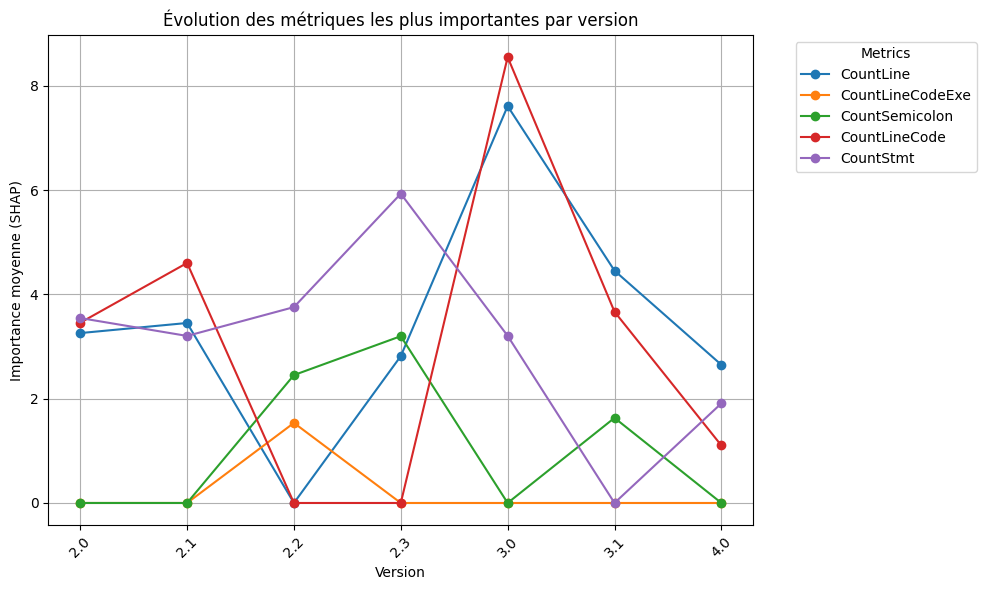

In [18]:
# Initialize a list to store the rows of the DataFrame
rows = []

for version, features in metrics_values.items():
    row = {'version': version}
    for metric_name, metric_value in features:
        row[metric_name] = metric_value
    rows.append(row)  # Ajouter la ligne à la liste

# Convert list to DataFrame
df_metrics = pd.DataFrame(rows)

# Fill missing values with 0 (or NaN as needed)
df_metrics = df_metrics.fillna(0)

# Plot the graph
plt.figure(figsize=(10, 6))
for metric in best_metrics:
    if metric in df_metrics:
        plt.plot(
            df_metrics['version'],
            df_metrics[metric],
            label=metric,
            marker='o'
        )

# AAdd details to the graph
plt.xlabel('Version')
plt.ylabel('Importance moyenne (SHAP)')
plt.title('Évolution des métriques les plus importantes par version')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the graph
plt.show()